## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

#### Create new feature prev_sold_year from prev_sold_date

In [3]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             459 non-null    float64
 1   bath            459 non-null    float64
 2   acre_lot        459 non-null    float64
 3   zip_code        459 non-null    float64
 4   house_size      459 non-null    float64
 5   price           459 non-null    float64
 6   prev_sold_year  459 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 25.2 KB


#### Find the zip code of that has the most houses.

In [4]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

2127.0

#### Find the rows of the zip code that has the most houses.

In [5]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

#### Create common variables to store frequently used values.

In [6]:
features = ["acre_lot","bed","bath","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [7]:
X = one_zipcode_df[features]
y = one_zipcode_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [8]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [9]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [10]:
dtree_gscv = GridSearchCV(DecisionTreeRegressor(random_state=42), {'min_samples_leaf': np.arange(1,7,1)})
dtree_gscv_model = dtree_gscv.fit(X, y)
print(f"Best parameters found: {dtree_gscv.best_params_}")

Best parameters found: {'min_samples_leaf': 1}


#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [11]:
dtree = DecisionTreeRegressor(**dtree_gscv.best_params_)
dtree_gscv = GridSearchCV(dtree, param_grid={})
dtree_model = dtree_gscv.fit(X_train,y_train)
dtree_predict = dtree_model.predict(X_test)

print_more_stuff("Decision Tree Best Params", y_test, dtree_predict, dtree_gscv)

Decision Tree Best Params EVS = 0.403611059
Decision Tree Best Params MSE = 105,262,833,333.333328
Decision Tree Best Params MAE = 204,500.000000
Decision Tree Best Params R2 = 0.061791
Decision Tree Best Params Fit Time = 0.0007294178009033203


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [12]:
dtree_rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_rfe.fit(X, y)
dtree_rfe_selected_features = dtree_rfe.get_support()
print('The selected features are:', list(X.columns[dtree_rfe_selected_features]))

The selected features are: ['bed', 'bath', 'house_size', 'prev_sold_year']


In [13]:
X_rfe = one_zipcode_df[list(X.columns[dtree_rfe_selected_features])]
y_rfe = one_zipcode_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [14]:
dtree_rfe_gscv = GridSearchCV(DecisionTreeRegressor(), param_grid={})
dtree_rfe_model = dtree_rfe_gscv.fit(X_rfe_train,y_rfe_train)
dtree_rfe_predict = dtree_rfe_model.predict(X_rfe_test)
print_more_stuff("Recursive Feature Elimination", y_rfe_test, dtree_rfe_predict, dtree_rfe_gscv)

Recursive Feature Elimination EVS = 0.407342641
Recursive Feature Elimination MSE = 105,236,833,333.333328
Recursive Feature Elimination MAE = 203,500.000000
Recursive Feature Elimination R2 = 0.062022
Recursive Feature Elimination Fit Time = 0.0


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [15]:
dtree_sfs = SequentialFeatureSelector(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_sfs.fit(X, y)
dtree_sfs_selected_features = dtree_sfs.get_support()
print('The selected features are:', list(X.columns[dtree_sfs_selected_features]))

The selected features are: ['acre_lot', 'bed', 'bath', 'house_size']


In [16]:
X_sfs = one_zipcode_df[list(X.columns[dtree_sfs_selected_features])]
y_sfs = one_zipcode_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [17]:
dtree_sfs_gscv = GridSearchCV(DecisionTreeRegressor(), param_grid={})
dtree_sfs_model = dtree_sfs_gscv.fit(X_sfs_train,y_sfs_train)
dtree_sfs_predict = dtree_sfs_model.predict(X_sfs_test)
print_more_stuff("Sequential Feature Selector", y_sfs_test, dtree_sfs_predict, dtree_sfs_gscv)

Sequential Feature Selector EVS = 0.411193064
Sequential Feature Selector MSE = 93,894,833,333.333328
Sequential Feature Selector MAE = 233,500.000000
Sequential Feature Selector R2 = 0.163114
Sequential Feature Selector Fit Time = 0.0


#### Graphing the results works best when the data is provided in a DataFrame.

In [18]:
dtree_predict_df = pd.DataFrame(dtree_predict).reset_index()
dtree_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

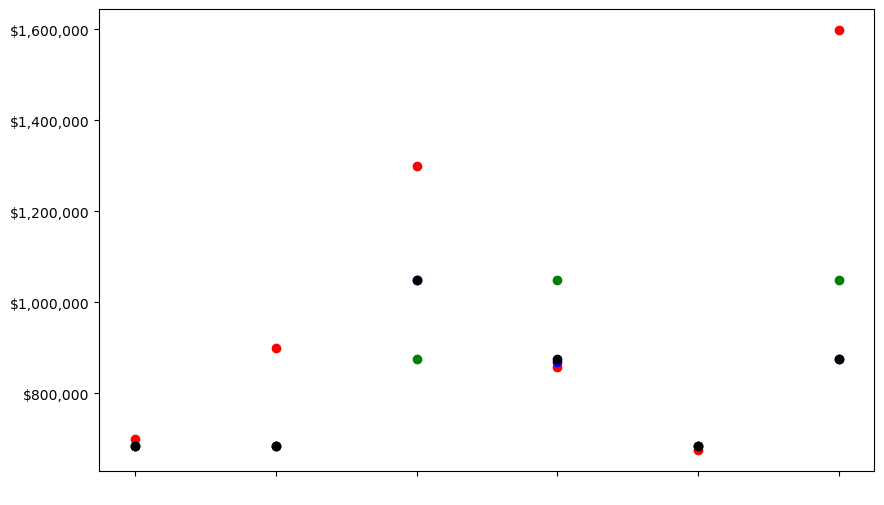

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.scatter(dtree_predict_df.index,dtree_predict_df["prediction"], color="black")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [20]:
dtree_predict_df.sort_values(by='prediction', inplace=True)
dtree_predict_df.reset_index(inplace=True)

dtree_sfs_predict_df.sort_values(by='prediction', inplace=True)
dtree_sfs_predict_df.reset_index(inplace=True)

dtree_rfe_predict_df.sort_values(by='prediction', inplace=True)
dtree_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

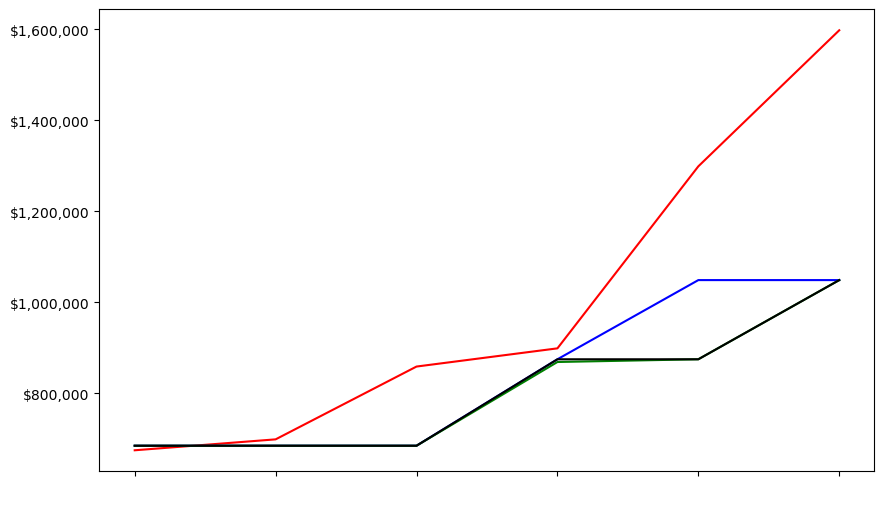

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="blue")
plt.plot(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="green")
plt.plot(dtree_predict_df.index,dtree_predict_df["prediction"], color="black")
plt.show()

In [22]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.403611059', '0.407342641', '0.411193064'],
 'mae score': ['204,500.000000', '203,500.000000', '233,500.000000'],
 'mse score': ['105,262,833,333.333328',
  '105,236,833,333.333328',
  '93,894,833,333.333328'],
 'r2 score': ['0.061791', '0.062022', '0.163114'],
 'mean fit time': [0.0007294178009033203, 0.0, 0.0]}

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.403611059,"204,500.000000","105,262,833,333.333328",0.061791,0.000729
Recursive Feature Elimination,0.407342641,"203,500.000000","105,236,833,333.333328",0.062022,0.000000
Sequential Feature Selector,0.411193064,"233,500.000000","93,894,833,333.333328",0.163114,0.000000
